In [1]:
import numpy as np
from pybads.bads import BADS
from pyvbmc import VBMC

In [74]:
import numpy as np
from scipy.special import psi, polygamma
import time

class IBS:
    
    """
    IBS class for computing the negative log-likelihood of a simulator based model.
    """
    # vectorized as True by default
    # exitflag
    
    def __init__(self, fun, resp_mat, design_mat, vectorized = None, acceleration=1.5, num_samples_per_call=0, max_iter=1e5, max_time=np.inf,
                  max_samples = 1e4, acceleration_threshold = 0.1, vectorized_threshold = 0.1,max_mem = 1e6, negLogL_threshold = np.inf):
 
        self.fun = fun
        self.resp_mat = np.atleast_1d(resp_mat)
        self.design_mat = design_mat
        self.vectorized = vectorized        # Use vectorized sampling algorithm with acceleration
        self.acceleration = acceleration    # Acceleration factor for vectorized sampling
        self.num_samples_per_call = num_samples_per_call    # Number of starting samples per trial per function call (0 = choose automatically)
        self.max_iter = max_iter    # Maximum number of iterations (per trial and estimate)
        self.max_time = max_time    # Maximum time for a IBS call (in seconds)
        self.max_samples = max_samples # maximum number of samples per function call
        self.acceleration_threshold = acceleration_threshold # keep accelerating until this threshold is reached (in s)
        self.vectorized_threshold = vectorized_threshold # maximum threshold for using vectorized algorithm (in s)
        self.max_mem = max_mem # maximum number of samples for vectorized implementation
        self.negLogL_threshold = negLogL_threshold # threshold for negative log-likelihood

    
    def __call__(self, params, num_reps=10, trial_weights=None, additional_output = None, return_positive=False):
        # if addititnal_output equals 'full' this function returns additional information:
        # infodict: dict of optional outputs {'funct_count': number of function evaluations, 'number_samples_total': num_samples_total/num_trials}
        # exitflag: integer flag indicating the exit condition of the optimization algorithm


        """
        Compute the negative log-likelihood of a simulator based model.
        
        Output:
        nlogl - negative log-likelihood (if return_positive is False else positive log-likelihood)
        nlogl_var - variance of negative log-likelihood estimate (if additional_output is 'var')
        nlogl_std - standard deviation of negative log-likelihood estimate (if additional_output is 'std')

        additional_output - None = return estimate
                            'var' = return estimate, variance
                            'std' = return estimate, standard deviation
                            'full' = return dictionary type output: ['nlogl', 'nlogl_var', 'exit_flag', 'message', 'num_samples_per_trial', 'fun_count']

        exitflag - exit flag (0 = correct termination, 1 = negative log-likelihood threshold reached, 2 = maximum runtime or maximum iterations reached)
        """
        t0 = time.perf_counter()
        num_trials = self.resp_mat.shape[0]

        # WEIGHT vector should be a scalar or same length as number of trials
        weights = 1.0
        if trial_weights is not None: weights = trial_weights.reshape(-1)
        if not np.isscalar(weights) and len(weights) != num_trials: raise ValueError('IBS:SizeMismatch',
                                                                                    'Length of trial_weights must match the number of trials')

        def compute_logl(self, params,num_reps, weights, return_positive,t0):

            
            sim_data = None
            elapsed_time = 0
            num_reps = int(num_reps)

            # use vectorized or loop version?
            if self.vectorized is None:
                start = time.time()
                if self.design_mat is None:
                    sim_data = self.fun(params, np.arange(num_trials))
                else: sim_data = self.fun(params, self.design_mat)
                elapsed_time = time.time() - start
                vectorized_flag = elapsed_time < self.vectorized_threshold       
            else: 
                vectorized_flag = self.vectorized

            def get_LL_from_K(psi_tab, K_mat):
                """
                Convert matrix of K values into log-likelihoods.
                """
                K_max = max(1, np.max(K_mat))
                if K_max > len(psi_tab):   # Fill digamma function table
                    psi_tab = np.concatenate((psi_tab, psi(1) - psi(np.arange(len(psi_tab)+1, K_max+1))))
                LL_mat = psi_tab[np.maximum(1, K_mat.astype(int)) - 1]
                return LL_mat, psi_tab

            def vectorized_ibs_sampling(params, sim_data0, elapsed_time0, t0, num_reps):
                
                num_trials = self.resp_mat.shape[0]
                trials = np.arange(num_trials) # enumerate the trials
                num_samples_total = 0 # total number of samples drawn
                fun_count = 0
                Psi_tab = []
                exitflag = 0

                # Empty matrix of K values (samples-to-hit) for each repeat for each trial
                K_mat = np.zeros((num_reps, num_trials), dtype=int)

                # Matrix of rep counts
                K_place0 = np.tile(np.arange(num_reps)[:, np.newaxis], (1,num_trials))

                # Current rep being sampled for each trial
                Ridx = np.zeros(num_trials)

                # Current vector of "open" K values per trial (not reached a "hit" yet)
                K_open = np.zeros(num_trials)

                target_hits = num_reps * np.ones(num_trials)
                max_iter = int(self.max_iter * num_reps)

                if self.num_samples_per_call == 0:
                    samples_level = num_reps
                else:
                    samples_level = self.num_samples_per_call
                
                for iter in range(max_iter):
                    # Pick trials that need more hits, sample multiple times
                    T = trials[Ridx < target_hits]
                    
                    # Check if max time has been reached
                    if np.isfinite(self.max_time) and time.perf_counter() - t0 > self.max_time: 
                        T = np.empty(0)
                        exitflag = 2
                        try:
                            raise RuntimeWarning('Warning in IBS execution: termination after maximum execution time was reached (the estimate can be arbitrarily biased)')
                        except RuntimeWarning as e: print(e)
                        
                    if len(T) == 0: break
                    num_consid_trials = len(T)
                    # With accelerated sampling, might request multiple samples at once
                    num_samples = min(max(1,np.round(samples_level)), self.max_samples)
                    max_samples = np.ceil(self.max_mem / num_consid_trials)
                    num_samples = min(num_samples, max_samples)
                    Tmat = np.tile(T, (int(num_samples),1))

                    # Simulate trials
                    if iter == 0 and num_samples == 1 and sim_data0 is not None:
                        sim_data = sim_data0
                        elapsed_time = elapsed_time0
                    else:
                        start = time.time()
                        if self.design_mat is None:
                            sim_data = self.fun(params, Tmat.reshape(-1))
                        else: 
                            sim_data = self.fun(params, self.design_mat[Tmat.reshape(-1)])
                        fun_count += 1
                        elapsed_time = time.time() - start
                    
                    # Check that the returned simulated data have the right size
                    if len(sim_data) != np.size(Tmat): raise ValueError('IBS: number of rows of returned simulated data does not match the number of requested trials')
                    
                    num_samples_total += num_consid_trials

                    # Accelerated sampling
                    if self.acceleration > 0 and elapsed_time < self.acceleration_threshold:
                        samples_level = samples_level * self.acceleration

                    # Check for hits
                    hits_temp = (self.resp_mat[Tmat.reshape(-1)] == sim_data)

                    def get_K_from_hits(hits_temp):

                        # Build matrix of new hits (sandwich with buffer of hits, then removed)
                        hits_new = np.concatenate((np.ones((1,num_consid_trials)), hits_temp.reshape(Tmat.shape), np.ones((1,num_consid_trials))), axis=0)
                        
                        # Extract matrix of Ks from matrix of hits for this iteration
                        list = np.nonzero(hits_new.T)
                        row = list[0]
                        delta = np.diff(np.append(list[1],0))
                        remove_idx = delta <= 0
                        row = row[~remove_idx]
                        delta = delta[~remove_idx]
                        index_col = np.nonzero(np.diff(np.concatenate((np.array([-1]),row))))
                        col = np.arange(len(row)) - np.take(index_col,row)
                        K_iter = np.zeros((len(T),np.max(col) + 1))
                        K_iter[row, col] = delta
                        return K_iter
                    
                    K_iter = get_K_from_hits(hits_temp)
                    
                    # Add K_open to first column of K_iter
                    K_iter[:,0] = K_iter[:,0] + K_open[T]

                    # Find last K position for each trial
                    index_last = np.argmin(np.hstack((K_iter, np.zeros(num_consid_trials).reshape(-1, 1))), axis=1) - 1
                    row_index = np.arange(len(T))
                    # Subtract one hit from last K (it was added)
                    K_iter[row_index, index_last] = K_iter[row_index, index_last] - 1
                    K_open[T] = K_iter[row_index, index_last]

                    # For each trial, ignore entries of K_iter past max number of reps
                    index_mat =  np.tile(np.arange(K_iter.shape[1])[:, np.newaxis], (1,num_consid_trials)) + Ridx[T]
                    K_iter[index_mat.T >= num_reps] = 0

                    # Find last K position for each trial again
                    index_last2 = np.argmin(np.hstack((K_iter, np.zeros(num_consid_trials).reshape(-1, 1))), axis=1) - 1

                    # Add current K to full K matrix
                    K_iter_place = (K_place0[:, :num_consid_trials] >= Ridx[T]) & (K_place0[:, :num_consid_trials] <= Ridx[T] + index_last2)
                    K_place = np.zeros_like(K_place0, dtype=bool)
                    K_place[:, T] = K_iter_place
                    K_mat_flat = K_mat.flatten('F')
                    K_mat_flat[K_place.flatten('F')] = K_iter[K_iter > 0].flatten()
                    K_mat = K_mat_flat.reshape(K_mat.shape, order='F')
                    Ridx[T] = Ridx[T] + index_last

                    # Compute log-likelihood only if requested for thresholding
                    if np.isfinite(self.negLogL_threshold):
                        Rmin = np.min(Ridx[T])
                        if Rmin >= K_mat.shape[0]: continue
                        LL_temp, Psi_tab = get_LL_from_K(Psi_tab, K_mat[int(Rmin),:])
                        nLL_temp = -np.sum(LL_temp, axis = 0)
                        if nLL_temp > self.negLogL_threshold:
                            index_move = Ridx == Rmin
                            Ridx[index_move] = Rmin + 1
                            K_open[index_move] = 0
                            exitflag = 1

                if len(T) != 0: 
                        try: raise RuntimeWarning('Warning in IBS execution: termination after maximum number of iterations was reached (the estimate can be arbitrarily biased)')
                        except RuntimeWarning as e: print(e)
                if np.isfinite(self.negLogL_threshold) and exitflag == 1:
                        try: raise RuntimeWarning('Warning in IBS execution: termination after negative log-likelihood threshold was reached (the estimate is biased)')
                        except RuntimeWarning as e: print(e)

                # Compute log-likelihood
                num_reps_per_trial = np.sum(K_mat > 0, axis=0) #number of repitions of the single trials 
                LL_mat, Psi_tab = get_LL_from_K(Psi_tab, K_mat)
                nlogl = -np.sum(LL_mat, axis=0)/num_reps_per_trial
                K = K_mat.T

                return nlogl, K, num_reps_per_trial, num_samples_total, fun_count, exitflag
        
            def loop_ibs_sampling(params, sim_data0, t0, num_reps):

                num_trials = self.resp_mat.shape[0]
                
                trials = np.arange(num_trials) # enumerate the trials
                max_iter = self.max_iter

                K = np.zeros((num_trials, num_reps)) #saves the # of iterations needed for the sample to match the trial response
                num_samples_total = 0 # total number of samples drawn
                fun_count = 0
                psi_tab = []
                exitflag = 0

                for iRep in range(num_reps):
                    offset = 1
                    hits = np.full(num_trials,False)
                    if np.isfinite(self.max_time) and time.perf_counter() - t0 > self.max_time: 
                        if exitflag != 2:
                            exitflag = 2
                            try: raise RuntimeWarning('Warning in IBS execution: termination after maximum execution time was reached (the estimate can be arbitrarily biased)')
                            except RuntimeWarning as e: print(e)
                        break

                    for iter in range(max_iter):
                        T = trials[hits == False]
                        if len(T) == 0: break
                        if iter == 0 and iRep == 0 and sim_data0 is not None:
                            sim_data = sim_data0
                            fun_count += 1
                        elif self.design_mat is None:
                            # call function with input params only for the trials that have not been hit yet
                            sim_data = self.fun(params, T)
                        else:
                            # call function with input params and design_mat only for the trials that have not been hit yet
                            sim_data = self.fun(params, self.design_mat[T]) 
                            fun_count += 1
                            
                        if np.shape(np.atleast_1d(sim_data))[0] != len(T): raise ValueError('IBS: number of rows of returned simulated data does not match the number of requested trials')
                        num_samples_total += len(T)
                        hits_new = (sim_data == self.resp_mat[T])
                        hits[T] = hits_new

                        K[np.atleast_1d(T)[hits_new], iRep] = offset
                        offset += 1

                        if np.isfinite(self.negLogL_threshold):
                            K[hits == False, iRep] = offset
                            LL_mat, psi_tab = get_LL_from_K(psi_tab, K[:, iRep])
                            nlogl = -np.sum(LL_mat, axis=0) # compute the negative log-likelihood of the current repetition
                            if nlogl > self.negLogL_threshold: 
                                T = []
                                exitflag = 1
                                try: raise RuntimeWarning('Warning in IBS execution: termination after negative log-likelihood threshold was reached (the estimate is biased)')
                                except RuntimeWarning as e: print(e)
                                break
                        # Terminate if above maximum allowed runtime
                        if np.isfinite(self.max_time) and time.perf_counter() - t0 > self.max_time: 
                            T = []
                            exitflag = 2
                            try: raise RuntimeWarning('Warning in IBS execution: termination after maximum execution time was reached (the estimate can be arbitrarily biased)')
                            except RuntimeWarning as e: print(e)
                            break
                    
                    if len(T) != 0: 
                        exitflag = 2
                        try: raise RuntimeWarning('Warning in IBS execution: termination after maximum number of iterations was reached (the estimate can be arbitrarily biased)')
                        except RuntimeWarning as e:
                            print(e)
                        

                num_reps_per_trail = np.sum(K > 0, axis=1) #number of repitions of the single trials 
                LL_mat, psi_tab = get_LL_from_K(psi_tab, K)
                nlogl = -np.sum(LL_mat, axis=1)/num_reps_per_trail

                return nlogl, K, num_reps_per_trail, num_samples_total, fun_count, exitflag

            if vectorized_flag:
                nlogl, K, num_reps_per_trial, num_samples_total, fun_count, exitflag  = vectorized_ibs_sampling(params, sim_data, elapsed_time, t0, num_reps)
            else:
                nlogl, K, num_reps_per_trial, num_samples_total, fun_count, exitflag = loop_ibs_sampling(params, sim_data, t0, num_reps)
            

            nlogl = np.sum(nlogl*weights)
            if return_positive: nlogl = -nlogl
            return nlogl, K, num_reps_per_trial, num_samples_total, fun_count, exitflag
        
        nlogl, K, num_reps_per_trial, num_samples_total, fun_count, exitflag = compute_logl(self, params, num_reps, weights, return_positive, t0)

        if additional_output in [None, 'none']:
            return nlogl

        if additional_output not in [None, 'none']:
            #compute variance of log-likelihood
            K_max = np.amax(K, initial=1)
            Ktab = - polygamma(1,np.arange(1, K_max + 1)) + polygamma(1,1)
            LLvar = Ktab[np.maximum(1, K.astype(int)) - 1]
            nlogl_var = np.sum(LLvar, axis=1)/num_reps_per_trial**2
            nlogl_var = np.sum(nlogl_var*(weights**2))
            if additional_output == 'var': return nlogl, nlogl_var
            if additional_output == 'std': return nlogl, np.sqrt(nlogl_var)
            if additional_output == 'full': return dict(nlogl=nlogl, nlogl_var=nlogl_var, nlogl_std=np.sqrt(nlogl_var), exit_flag=exitflag, elapsed_time = time.perf_counter() - t0,num_samples_per_trial=num_samples_total/num_trials, fun_count = fun_count)
        else: raise ValueError('IBS:InvalidArgument', 'Invalid value for additional_output.')

In [3]:
import numpy.random as npr
from scipy.stats import norm

def psycho_gen(theta, S):
    """
    Generate responses for psychometric function model
    (simple orientation discrimination task).
    
    Inputs:
    S: np.array
        stimulus orientation (in deg) for each trial
    theta: np.array with 3 elements
        model parameter vector, with THETA(0) as eta=log(sigma),
        the log of the sensory noise; THETA(1) the bias term;
        THETA(2) is the lapse rate
    
    Returns:
    R: np.array
        responses per trial, 1 for "rightwards" and -1 for "leftwards"
    """
    # Extract model parameters
    sigma = np.exp(theta[0])
    bias = theta[1]
    lapse = theta[2]

    # Noisy measurement
    X = S + sigma * npr.randn(np.size(S))

    # Decision rule
    R = np.zeros(np.size(S))
    R[X >= bias] = 1
    R[X < bias] = -1

    # Lapses
    lapse_idx = npr.rand(np.size(S)) < lapse
    lapse_val = npr.randint(2, size=np.sum(lapse_idx)) * 2 - 1
    R[lapse_idx] = lapse_val

    return R


def psycho_nll(theta, S, R):
    """Negative log-likelihood for psychometric function model.
    
    Inputs:
    S: np.array
        stimulus orientation (in deg) for each trial
    theta: np.array with 3 elements
        model parameter vector, with THETA(1) as eta=log(sigma),
        the log of the sensory noise; THETA(2) the bias term;
        THETA(3) is the lapse rate
    R: np.array
        vector of responses, 1 for "rightwards" and -1 for "leftwards"

    Returns:
    L: float
        negative log-likelihood
    """
    
    # Extract model parameters
    sigma = np.exp(theta[0])
    bias = theta[1]
    lapse = theta[2]
    
    # Likelihood per trial (analytical solution)
    
    p_vec = lapse / 2 + (1 - lapse) * ((R == -1) * norm.cdf(-(S - bias) / sigma) + (R == 1) * norm.cdf((S - bias) / sigma))

    # Total negative log-likelihood
    L = -np.sum(np.log(p_vec))

    return L

Example script for running inverse binomial sampling (IBS)

In this example, we fit some simple orientation discrimination data using IBS, BADS and PyVBMC.

First, we simulate a synthetic dataset to fit.

In [56]:
fun = psycho_gen
Ntrials = 600
eta = np.log(1) #Fake subject (log) sensory noise
bias = 0.2  # Fake subject response bias
lapse = 0.03 # Fake subject lapse rate
# Generating parameter vector
params = np.array([eta, bias, lapse])

# Generate stimulus orientation per trial
design_mat = 3*npr.rand(Ntrials)
# Generate fake subject responses
resp_mat = psycho_gen(params,design_mat)

# We set the lower/upper bounds for the parameters (in particular, note that 
# we set a nonzero lower bound for the lapse rate)
lb = np.array([np.log(0.1), -2, 0.01])
ub = np.array([np.log(10), 2, 0.99])

# We also set the "plausible" lower/upper bounds representing where we
# would expect to find most parameters (this is not a prior, it just
# identifies a region e.g. for the starting points)
plb = np.array([np.log(0.2), -1, 0.02])
pub = np.array([np.log(5), 1, 0.1])

### Maximum-likelihood estimation (MLE)

We fit the data via maximum-likelihood estimation using Bayesian Adaptive  Direct Search (BADS), a particularly effective optimization algorithm for noisy target functions.

We define the negative log-likelihood function via a call to IBS.
We set 10 reps for the IBS estimator. We also tell IBS to return as a second output the standard deviation  of the estimate (as opposed to the variance).

In [77]:
ibs = IBS(fun, resp_mat, design_mat, vectorized=True, acceleration=1.5, num_samples_per_call=0, max_iter=int(1e5), max_time=np.inf)
target = lambda theta: ibs(theta, additional_output='std')

# As a starting point for the optimization, we draw a sample inside the
# plausible box (in practice you should use multiple restarts!)
theta0 = plb + npr.rand(3) * (pub - plb)

# We inform BADS that IBS returns noise estimate (standard deviation) as second output
bads_options = {
    "specify_target_noise": True,
    "uncertainty_handling": True
}


In [78]:
bads_exact = BADS(lambda theta: psycho_nll(theta,design_mat,resp_mat), theta0, lb, ub, plb, pub)
theta_exact = bads_exact.optimize()

bads = BADS(target, theta0, lb, ub, plb, pub,options=bads_options)
theta_ibs= bads.optimize()

Beginning optimization of a DETERMINISTIC objective function

 Iteration    f-count         f(x)           MeshScale          Method             Actions
     0           2          344.96               1                                 Uncertainty test
     0           6         213.957               1         Initial mesh            Initial points
     0           8         212.574               1       Successful poll           Train
     1          10         201.045               1     Successful search (ES-wcm)        
     1          16         200.292               1     Incremental search (ES-wcm)        
     1          22         199.696             0.5         Refine grid             Train
     2          25         199.569             0.5     Incremental search (ES-ell)        
     2          32         199.498            0.25         Refine grid             Train
     3          33         199.307            0.25     Successful search (ES-wcm)        
     3          35  

c:\Users\julia\anaconda3\lib\site-packages\scipy\stats\_morestats.py:1805: RuntimeWarning: invalid value encountered in subtract
  x = x - np.median(x)


     6          76         199.244       0.0078125         Refine grid             Train
     7          78         199.244       0.0078125     Incremental search (ES-wcm)        
     7          86         199.244      0.00195312         Refine grid             Train
Optimization terminated: change in the function value less than options.TolFun.
Function value at minimum: 199.24428993366075

Beginning optimization of a STOCHASTIC objective function (specified noise)

 Iteration    f-count      E[f(x)]        SD[f(x)]           MeshScale          Method              Actions
     0           1         341.345         3.80161               1                                  
     0          33         203.255         3.80161               1          Initial mesh            Initial points
     0          34          196.58         1.74472               1        Successful poll           Train
     1          44          196.58         1.74472             0.5          Refine grid          

Analysis of results

In [79]:
print("Returned maximum-likelihood solutions with different methods:")
print("Analitical log-likelihood: ", theta_exact["x"])
print("IBS log-likelihood: ", theta_ibs["x"])
print("Data generating parameters: ", params)

nlogl_ibs,nlogl_std = ibs(theta_ibs["x"], additional_output='std',num_reps=100)
nll_exact = psycho_nll(theta_exact["x"],design_mat,resp_mat)

print(f'Estimated log-likelihood at the IBS-found solution: {-nlogl_ibs:.2f} +/- {nlogl_std:.2f} (exact value: {-psycho_nll(theta_ibs["x"],design_mat, resp_mat):.2f}).')

# We also evaluate the MLE found exactly
print(f'Log-likelihood at the exact-found solution: {-nll_exact:.2f}.')

# Note that even the exact MLE will differ from the true data-generating
# parameters due to finiteness of the dataset (we expect to recover the 
# true data generating parameters in the limit NTRIALS -> infinity)

Returned maximum-likelihood solutions with different methods:
Analitical log-likelihood:  [-0.06725401  0.14142764  0.02736585]
IBS log-likelihood:  [-0.02291509  0.14974956  0.01000732]
Data generating parameters:  [0.   0.2  0.03]
Estimated log-likelihood at the IBS-found solution: -198.79 +/- 1.21 (exact value: -199.48).
Log-likelihood at the exact-found solution: -199.24.


### Bayesian Posterior Estimation

We now fit the same data via a method that computes the Bayesian posterior over model parameters, called Variational Bayesian Monte Carlo (VBMC).

For VBMC, we need to return the POSITIVE log-likelihood as first output, and the standard deviation (not variance!) of the estimate as second output.

In [80]:
from scipy.stats import trapezoid

log_likelihood = lambda theta: ibs(theta, additional_output='std', num_reps=100, return_positive = True)
# num_reps = 100 to try and have a SD ~ 1 (and below 3)

# Set the lower/upper bounds for the parameters
lb = np.array([np.log(0.1), -2, 0.01])
ub = np.array([np.log(10), 2, 1])

# Set the "plausible" lower/upper bounds
plb = np.array([np.log(0.2), -1, 0.02])
pub = np.array([np.log(5), 1, 0.05])

# Trapezoidal or “tent” prior over the parameters (flat between PLB and PUB, and linearly decreasing to 0 towards LB and UB).
def log_prior(x):
    c = (plb - lb) / (ub - lb)
    d = (pub - lb) / (ub - lb)
    loc = lb
    scale = ub - lb
    y = trapezoid.logpdf(x, c, d, loc, scale)
    return np.sum(y)

# Full model:
def log_joint(theta):
    """log-density of the joint distribution."""
    log_p = log_prior(theta)
    log_l, noise_est = log_likelihood(theta)
    # For the joint, we have to add log densities and carry-through the noise estimate.
    return log_p + log_l, noise_est

# Here we could use as starting point the result of a run of BADS
theta0 = 0.5*(plb + pub)
options = {"specify_target_noise": True}
vbmc = VBMC(log_joint,theta0,lb,ub,plb,pub,options=options)

Reshaping x0 to row vector.
Reshaping lower bounds to (1, 3).
Reshaping upper bounds to (1, 3).
Reshaping plausible lower bounds to (1, 3).
Reshaping plausible upper bounds to (1, 3).


In [81]:
# run VBMC

np.random.seed(42)
vp, results = vbmc.optimize()

Beginning variational optimization assuming NOISY observations of the log-joint
 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
     0         10        -202.97        13.72      4984.16        2        inf     start warm-up
     1         15        -206.78         0.93        12.14        2        inf     
     2         20        -206.70         0.59         1.22        2       24.2     
     3         25        -207.00         0.41         0.04        2       1.39     
     4         30        -206.97         0.37         0.10        2       2.23     
     5         35        -207.23         0.31         0.08        2       2.02     
     6         40        -207.13         0.31         0.38        2       7.62     end warm-up
     7         45        -206.96         0.33         0.14        2        3.2     
     8         50        -206.90         0.29         0.08        2       1.87     
     9         55        -206.82         0.29     

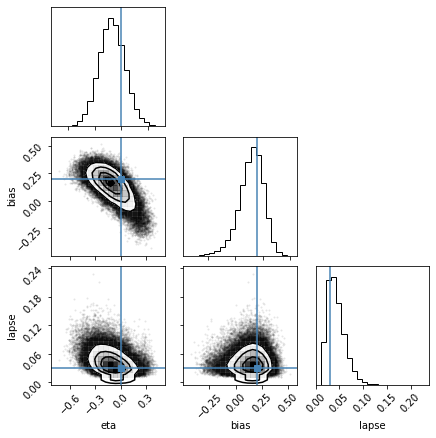

In [103]:
vp.plot(plot_style = { 'corner' : {'truths': params, 'labels':["eta", "bias", "lapse"]}});

The blue lines represent the true generating parameters for the fake dataset.